<a href="https://colab.research.google.com/github/sergiomora03/AdvancedTopicsAnalytics/blob/main/notebooks/L23-DeepWalk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creating Node Representations with DeepWalk

### Skip-gram Algorithm in Word2Vec

In [4]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 77.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 95.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 15.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.2
    Uninstalling scipy-1.15.2:
      Successfully uninstalled scipy-1.15.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [3]:
np.__version__

'1.26.4'

In [2]:
import numpy as np
np.random.seed(0)

CONTEXT_SIZE = 2

text = """Lorem ipsum dolor sit amet, consectetur adipiscing elit. Nunc eu sem
scelerisque, dictum eros aliquam, accumsan quam. Pellentesque tempus, lorem ut
semper fermentum, ante turpis accumsan ex, sit amet ultricies tortor erat quis
nulla. Nunc consectetur ligula sit amet purus porttitor, vel tempus tortor
scelerisque. Vestibulum ante ipsum primis in faucibus orci luctus et ultrices
posuere cubilia curae; Quisque suscipit ligula nec faucibus accumsan. Duis
vulputate massa sit amet viverra hendrerit. Integer maximus quis sapien id
convallis. Donec elementum placerat ex laoreet gravida. Praesent quis enim
facilisis, bibendum est nec, pharetra ex. Etiam pharetra congue justo, eget
imperdiet diam varius non. Mauris dolor lectus, interdum in laoreet quis,
faucibus vitae velit. Donec lacinia dui eget maximus cursus. Class aptent taciti
sociosqu ad litora torquent per conubia nostra, per inceptos himenaeos. Vivamus
tincidunt velit eget nisi ornare convallis. Pellentesque habitant morbi
tristique senectus et netus et malesuada fames ac turpis egestas. Donec
tristique ultrices tortor at accumsan.
""".split()

# Create skipgrams
skipgrams = []
for i in range(CONTEXT_SIZE, len(text) - CONTEXT_SIZE):
    array = [text[j] for j in np.arange(i - CONTEXT_SIZE, i + CONTEXT_SIZE + 1) if j != i]
    skipgrams.append((text[i], array))

print(skipgrams[0:2])

[('dolor', ['Lorem', 'ipsum', 'sit', 'amet,']), ('sit', ['ipsum', 'dolor', 'amet,', 'consectetur'])]


In [4]:
vocab = set(text)
VOCAB_SIZE = len(vocab)
print(f"Length of vocabulary = {VOCAB_SIZE}")

Length of vocabulary = 121


In [5]:
from gensim.models.word2vec import Word2Vec

# Create Word2Vec
model = Word2Vec([text],
                 sg=1,   # Skip-gram
                 vector_size=10,
                 min_count=0,
                 window=2,
                 workers=1,
                 seed=0)

print(f'Shape of W_embed: {model.wv.vectors.shape}')

# Train model
model.train([text], total_examples=model.corpus_count, epochs=10)

# Print a word embedding
print('\nWord embedding =')
print(model.wv[0])

Shape of W_embed: (121, 10)

Word embedding =
[ 0.07156403  0.03257632  0.00209916 -0.04374931 -0.03398107 -0.08656936
 -0.09047253 -0.0955243  -0.06482638  0.0660186 ]


### Random walks between neighboring nodes
Note: network homophily hypothesis

/usr/local/lib/python3.11/dist-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


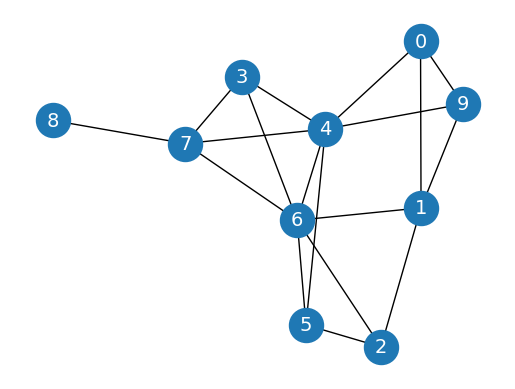

In [6]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a graph
G = nx.erdos_renyi_graph(10, 0.3, seed=1, directed=False)

# Plot graph
plt.figure()
plt.axis('off')
nx.draw_networkx(G,
                 pos=nx.spring_layout(G, seed=0),
                 node_size=600,
                 cmap='coolwarm',
                 font_size=14,
                 font_color='white'
                 )

In [7]:
import random
random.seed(0)

def random_walk(start, length):
    walk = [str(start)]  # starting node

    for i in range(length):
        neighbors = [node for node in G.neighbors(start)]
        next_node = np.random.choice(neighbors, 1)[0]
        walk.append(str(next_node))
        start = next_node

    return walk

# Create a list of random walks
print(random_walk(0, 10))

['0', '1', '9', '1', '0', '4', '6', '7', '6', '5', '6']


### DeepWalk implementation

In [8]:
# Load dataset
G = nx.karate_club_graph()

example_1 = 30 # Choice random node
example_2 = 4 # Choice random node
print(f'Node {example_1} information: {G.nodes[example_1]}')
print(f'Node {example_2} information: {G.nodes[example_2]}')

Node 30 information: {'club': 'Officer'}
Node 4 information: {'club': 'Mr. Hi'}


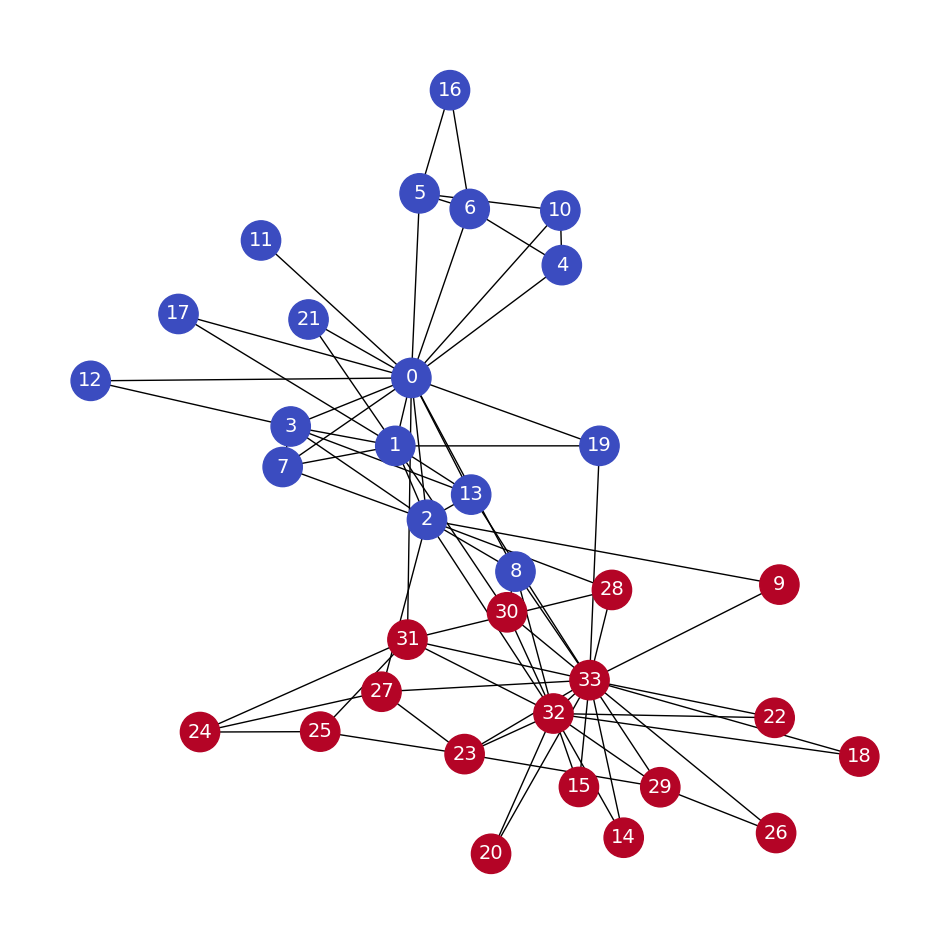

In [9]:
# Process labels (Mr. Hi = 0, Officer = 1)
labels = []
for node in G.nodes:
    label = G.nodes[node]['club']
    labels.append(1 if label == 'Officer' else 0)

# Plot graph
plt.figure(figsize=(12,12))
plt.axis('off')
nx.draw_networkx(G,
                 pos=nx.spring_layout(G, seed=0),
                 node_color=labels,
                 node_size=800,
                 cmap='coolwarm',
                 font_size=14,
                 font_color='white'
                 )

In [10]:
# Create a list of random walks
walks = []
for node in G.nodes:
    for _ in range(80): # 80: number random walks
        walks.append(random_walk(node, 10)) # 10: walk length

# Print the first random walk
print(walks[0])

['0', '10', '0', '17', '0', '2', '13', '0', '2', '9', '33']


In [11]:
# Create Word2Vec
model = Word2Vec(walks,
                 hs=1,   # Hierarchical softmax
                 sg=1,   # Skip-gram
                 vector_size=100,
                 window=10,
                 workers=1,
                 seed=1)

print(f'Shape of embedding matrix: {model.wv.vectors.shape}')

# Build vocabulary
model.build_vocab(walks)

# Train model
model.train(walks, total_examples=model.corpus_count, epochs=30, report_delay=1)

Shape of embedding matrix: (34, 100)


(186095, 897600)

In [12]:
# Most similar nodes
print('Nodes that are the most similar to node 0:')
for similarity in model.wv.most_similar(positive=['0']):
    print(f'   {similarity}')

# Similarity between two nodes
print(f"\nSimilarity between node 0 and 4: {model.wv.similarity('0', '4')}")

Nodes that are the most similar to node 0:
   ('7', 0.6418899893760681)
   ('11', 0.6362671256065369)
   ('10', 0.6353005766868591)
   ('4', 0.6283879280090332)
   ('1', 0.6240326762199402)
   ('17', 0.6081677675247192)
   ('6', 0.5763440132141113)
   ('5', 0.5598748326301575)
   ('21', 0.5572237372398376)
   ('16', 0.550387442111969)

Similarity between node 0 and 4: 0.6283879280090332


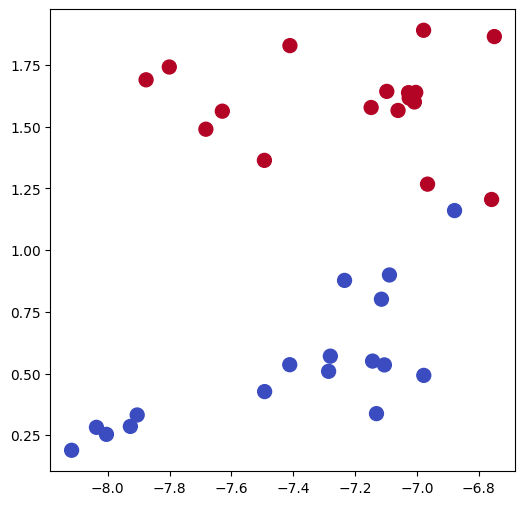

In [13]:
from sklearn.manifold import TSNE

# Preprocess word vectors and label
nodes_wv = np.array([model.wv.get_vector(str(i)) for i in range(len(model.wv))])
labels = np.array(labels)

# Train TSNE
tsne = TSNE(n_components=2,
            learning_rate='auto',
            init='pca',
            random_state=0).fit_transform(nodes_wv)

# Plot TSNE
plt.figure(figsize=(6, 6))
plt.scatter(tsne[:, 0], tsne[:, 1], s=100, c=labels, cmap="coolwarm")
plt.show()

### Node Classification

In [14]:
len(nodes_wv[0])

100

In [15]:
nodes_wv[0]

array([ 0.11975726,  0.31142992,  0.08290367,  0.0697763 , -0.07248324,
       -0.23806009, -0.02404001,  0.3976664 , -0.18363051, -0.02198286,
        0.12977396, -0.06191203, -0.05662876,  0.1323577 , -0.07738405,
       -0.01229624,  0.18979906,  0.16663925, -0.22609709, -0.32861882,
        0.01103505, -0.13831104,  0.19290261, -0.22433753, -0.11685721,
       -0.13566674, -0.03658428,  0.14449142, -0.17481469,  0.01985643,
        0.04999894, -0.2511147 ,  0.07854032, -0.23456298, -0.020038  ,
        0.13563876,  0.356726  ,  0.06147052, -0.16772538, -0.08477344,
       -0.19894244, -0.05357376, -0.28026164,  0.2710633 ,  0.04542569,
        0.01447583, -0.09947915, -0.03956262, -0.006552  ,  0.09166442,
       -0.13938348,  0.01399922, -0.06510059, -0.11853256, -0.00717601,
       -0.13421392, -0.06471453, -0.16787471, -0.11350361,  0.13513674,
       -0.01123696, -0.12231915, -0.01570199, -0.13046825, -0.06706714,
        0.21916421,  0.14567435,  0.09266914,  0.00897745,  0.07

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Create masks to train and test the model
train_mask = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24]
test_mask = [0, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33]

# Train classifier
clf = RandomForestClassifier(random_state=0)
clf.fit(nodes_wv[train_mask], labels[train_mask])

# Evaluate accuracy
y_pred = clf.predict(nodes_wv[test_mask])
acc = accuracy_score(y_pred, labels[test_mask])
print(f'Accuracy = {acc*100:.2f}%')

Accuracy = 90.91%


In [17]:
from sklearn.model_selection import train_test_split

# Create split to train and test the model
X = nodes_wv
y = labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=18)

# Train classifier
clf = RandomForestClassifier(random_state=0)
clf.fit(X_train, y_train)

# Evaluate accuracy
y_pred = clf.predict(X_test)
acc = accuracy_score(y_pred, y_test)
print(f'Accuracy = {acc*100:.2f}%')

Accuracy = 91.67%
